# **Damage Detection Using Ensemble Learning: A Comprehensive Analysis and Implementation Notebook**
---



>[Damage Detection Using Ensemble Learning: A Comprehensive Analysis and Implementation Notebook](#scrollTo=Ko-3w5ahytsa)

>[Data Preprocessing](#scrollTo=GzhjArf-EmPg)

>>[Importing necessary packages](#scrollTo=GzhjArf-EmPg)

>>[Importing the different datasets with distinct input features (PCA, RMSD, and extra)](#scrollTo=ymzrM00AEzmf)

>>[Allocating Key-Value Pairs from Mat Data to Tensors](#scrollTo=Tc_M-3S0FRNm)

>>[One-Hot Encoding of Training, Validation, and Test Datasets](#scrollTo=qO4SCOx3HbIf)

>>[Separating Data for Classification and Regression Loss](#scrollTo=G_IL7DDSSOOS)

>>[Selecting Input Features based on PCA Results and Variance](#scrollTo=0uIZ-DyzSD9S)

>>[Shuffeling data](#scrollTo=0AvjzeRDMxsG)

>>>[Normalizing the inputs](#scrollTo=-rZ4p7tFU4Mp)

>>>[Normalizing outputs](#scrollTo=fdzlsmk7k3Wo)

>[Definnig Support Vector Machine(SVM) using sklearn](#scrollTo=vVYc3s4_-Sw-)

>[Definnig Random Forest using sklearn](#scrollTo=A9YloWVNQP-M)

>[Defining ML model using functional API](#scrollTo=U8fmjmzfr8iv)

>>[Defining and training a Multi-Task Loss Function](#scrollTo=XafL2qfTyaV5)

>>>[Defining the model](#scrollTo=LAixckJV1o8n)

>>>[Defining the model architecture](#scrollTo=sYHQOQaku3ZQ)

>>[Evaluating the model using Learning Curve](#scrollTo=toTOorbsJavR)

>[Saving Models in Google Drive](#scrollTo=gXUc38PQgCRO)

>[Defining Ensemnle Learning Model](#scrollTo=KZ32v4MRRbuC)



# Data Preprocessing




## Importing necessary packages

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation,GaussianNoise
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
# from keras.utils.vis_utils import plot_model

In [2]:
import pandas as pd
import joblib
from google.colab import data_table
data_table.enable_dataframe_formatter()
from google.colab import drive
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.utils import class_weight

import pickle

# !pip install -Uqq ipdb
# import ipdb

In [3]:
if tf.test.gpu_device_name():
  print('GPU is available')
  print(tf.config.list_physical_devices('GPU'))

## Importing the different datasets with distinct input features (PCA, RMSD, and extra)
In this section of the Python notebook, we will import various datasets that contain different sets of input features. These features include PCA (Principal Component Analysis), RMSD (Root Mean Square Deviation), and additional features.

In [4]:
drive.mount('/content/drive')
mat_file_path = '/content/drive/MyDrive/Master Thesis/EMI-data/RMSDPCA4Regions10.mat'
data = scipy.io.loadmat(mat_file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'OutputTest', 'OutputTrain', 'OutputVal', 'inputTest', 'inputTrain', 'inputVal'])


## Allocating Key-Value Pairs from Mat Data to Tensors
In this section, we will focus on allocating key-value pairs from a Mat data file to tensors. The Mat file contains structured data with keys representing different features or variables, and values containing the corresponding data arrays. Our goal is to efficiently extract this data and convert it into tensor format, which is commonly used in deep learning frameworks like TensorFlow.

In [6]:
def keyvalue(data):
  input_test=tf.convert_to_tensor(data['inputTest'])
  input_val=tf.convert_to_tensor(data['inputVal'])
  input_train=tf.convert_to_tensor(data['inputTrain'])

  output_test=tf.convert_to_tensor(data['OutputTest'])
  output_val=tf.convert_to_tensor(data['OutputVal'])
  output_train=tf.convert_to_tensor(data['OutputTrain'])
  return input_train,input_val,input_test,output_train,output_val,output_test

## One-Hot Encoding of Training, Validation, and Test Datasets
In this section of the notebook, we will perform one-hot encoding on the training, validation, and test datasets. One-hot encoding is a common technique used to transform categorical variables into a binary representation that can be effectively used by machine learning algorithms.
By applying one-hot encoding, we will convert categorical variables in our datasets into binary columns, where each column represents a unique category. This transformation enables us to incorporate categorical information into our models accurately and efficiently.

## Separating Data for Classification and Regression Loss
In this section, we will split our dataset into two subsets: one for classification tasks and the other for regression tasks. This separation is crucial as different machine learning models and loss functions are often employed for these distinct problem types.

In [7]:
# One hot encoding of function and Separating Data for Classification and Regression Loss
def one_hot_converter(int_output):
  regions=tf.gather(int_output,1,axis=1)
  regions=tf.one_hot(regions,depth=4,axis=0)
  regions=tf.transpose(regions)

  sever=tf.gather(int_output,0,axis=1)
  sever = tf.cast(sever, dtype=tf.float32)
  sever=tf.reshape(sever, shape=(-1, 1))

  outputs=tf.concat([sever,regions],axis=1)
  return outputs

## Selecting Input Features based on PCA Results and Variance
After applying PCA to our data, we have obtained the results that capture the variance explained by each principal component.

In [8]:
def shuffeling(inputs,outputs,seed=40):
  tf.random.set_seed(seed)
  # # Shuffle the data tensors together
  shuffled_indices = tf.range(start=0, limit=tf.shape(inputs)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(shuffled_indices, seed=seed)
  inputs2 = tf.gather(inputs, shuffled_indices)
  outputs2 = tf.gather(outputs, shuffled_indices)
  return inputs2,outputs2


In [9]:
def SevNorm(output_sev,output_sev_val,output_sev_test):
  # Normalizing the outputs related to regressoin task
  # # Calculating the mean and standard deviation of the training targets
  mean_y_train = tf.reduce_mean(output_sev)
  std_y_train = tf.math.reduce_std(output_sev)
  # # Normalize the targets by subtracting the mean and dividing by the standard deviation
  output_sev2 = (output_sev - mean_y_train) / std_y_train
  output_val2 = (output_sev_val - mean_y_train) / std_y_train
  output_test2 = (output_sev_test - mean_y_train) / std_y_train
  return output_sev2,output_val2,output_test2

## Separating Data for Classification and Regression Loss
In this section, we will split our dataset into two subsets: one for classification tasks and the other for regression tasks. This separation is crucial as different machine learning models and loss functions are often employed for these distinct problem types.

In [10]:
def SeparatingOut(output_train,output_val,output_test):
  # deviding data into regression and classification datasets
  output_sev_train=tf.gather(output_train,0 ,axis=1)
  output_label_train=tf.gather(output_train,range(1,output_train.shape[1]),axis=1)

  output_sev_val=tf.gather(output_val,0 ,axis=1)
  output_label_val=tf.gather(output_val,range(1,output_val.shape[1]),axis=1)

  output_sev_test=tf.gather(output_test,0 ,axis=1)
  output_label_test=tf.gather(output_test,range(1,output_test.shape[1]),axis=1)
  return(output_sev_train,output_label_train,output_sev_val,output_label_val,
         output_sev_test,output_label_test)

## Selecting Input Features based on PCA Results and Variance
After applying PCA to our data, we have obtained the results that capture the variance explained by each principal component.

In [11]:
def FeatureSelecting(input_train,input_Val,input_Test,FeatureNum):
  input_train2=tf.gather(input_train,(range(0,FeatureNum)),axis=1)
  input_Val2=tf.gather(input_Val,(range(0,FeatureNum)),axis=1)
  input_Test2=tf.gather(input_Test,(range(0,FeatureNum)),axis=1)
  return input_train2,input_Val2, input_Test2

In [12]:
## Shuffeling data

In [13]:

# shuffled_indices = tf.range(start=0, limit=tf.shape(input_train)[0], dtype=tf.int32)
# shuffled_indices = tf.random.shuffle(shuffled_indices, seed=seed)
# input_train = tf.gather(input_train, shuffled_indices)
# output_reg = tf.gather(output_reg, shuffled_indices)
# # # output_log = tf.gather(output_log, shuffled_indices)


# shuffled_indices = tf.range(start=0, limit=tf.shape(input_Val)[0], dtype=tf.int32)
# shuffled_indices = tf.random.shuffle(shuffled_indices, seed=seed)
# input_Val = tf.gather(input_Val, shuffled_indices)
# output_regVal = tf.gather(output_regVal, shuffled_indices)

# shuffled_indices = tf.range(start=0, limit=tf.shape(input_Test)[0], dtype=tf.int32)
# shuffled_indices = tf.random.shuffle(shuffled_indices, seed=seed)
# input_Test = tf.gather(input_Test, shuffled_indices)
# output_regTest = tf.gather(output_regTest, shuffled_indices)

In [14]:
# output_sev_val=tf.gather(output_regVal,0 ,axis=1)
# output_label_val=tf.gather(output_regVal,range(1,output_reg.shape[1]),axis=1)

# output_sev=tf.gather(output_reg,0 ,axis=1)
# output_label=tf.gather(output_reg,range(1,output_reg.shape[1]),axis=1)

# output_sev_Test=tf.gather(output_regTest,0 ,axis=1)
# output_label_Test=tf.gather(output_regTest,range(1,output_reg.shape[1]),axis=1)

### Normalizing the inputs

In [15]:
def NormData(input_train,input_Val,input_Test,FeatureNum):
  meanIn=tf.math.reduce_mean(input_train,axis=0)
  varIn=tf.math.reduce_std(input_train,axis=0,keepdims=True)

  input_train=tf.math.divide(input_train-meanIn,varIn)
  input_Val=tf.math.divide(input_Val-meanIn,varIn)
  input_Test=tf.math.divide(input_Test-meanIn,varIn)
  input_train,input_Val,input_Test=FeatureSelecting(input_train,
                                                    input_Val,input_Test,FeatureNum)
  return input_train,input_Val,input_Test

### Normalizing outputs
To balance optimization across all tasks and prevent the regression output from dominating the total loss function, the regression output should be normalized, considering the classification outputs have a range of 0-1.

In [16]:
# # Calculate the mean and standard deviation of the training targets
# mean_y_train = tf.reduce_mean(output_sev)
# std_y_train = tf.math.reduce_std(output_sev)

# # Normalize the targets by subtracting the mean and dividing by the standard deviation
# output_sev2 = (output_sev - mean_y_train) / std_y_train
# output_sev_val2 = (output_sev_val - mean_y_train) / std_y_train
# output_sev_Test2 = (output_sev_Test - mean_y_train) / std_y_train

## Definning the Overal Preprocessing Steps in one function

In [17]:
def PreProcessing(data):

  #deviding data into train, validation and test datasets
  input_train,input_val,input_test,output_train,output_val,output_test=keyvalue(data)

  #-----------------------------------------------------------------------------
  # INPUT SIGNALS PROCESSING
  #-----------------------------------------------------------------------------
  # Shuffling the data tensors together
  input_train,output_train=shuffeling(input_train,output_train)
  input_val,output_val=shuffeling(input_val,output_val)
  input_test,output_test=shuffeling(input_test,output_test)
  FeatureNum=58
  # Normalizing input dataset and selecting features dimension.
  input_train,input_val,input_test=NormData(input_train,input_val,input_test,FeatureNum)

  #-----------------------------------------------------------------------------
  # OUTPUT SIGNALS PROCESSING
  #-----------------------------------------------------------------------------
  # Converting the classification outputs to one hot encoding format
  output_train=one_hot_converter(output_train)
  output_val=one_hot_converter(output_val)
  output_test=one_hot_converter(output_test)

  # deviding data into regression and classification datasets
  (
      output_sev_train,output_label_train,output_sev_val,output_label_val,
      output_sev_test,output_label_test
      )=SeparatingOut(output_train,output_val,output_test)

  # Normalizing the outputs related to regressoin task
  output_sev_train, output_sev_val, output_sev_test=SevNorm(output_sev_train,
                                                            output_sev_val,output_sev_test)
  #-----------------------------------------------------------------------------

  return input_train,input_val,input_test,output_sev_train,output_sev_val,output_sev_test,output_label_train,output_label_val,output_label_test

In [18]:
(input_train,input_val,input_test,output_train_sev,output_val_sev,
    output_test_sev,output_train_label,output_val_label,
    output_test_label)=PreProcessing(data)

#Using Support Vector Machine(SVM) with sklearn

In [ ]:
# The optimum hyperparameters:
CC=[100]
gamma=[0.0004]
#----------------------------
for j in gamma:

  for i in CC:

    #Step 1: transfor data to numpy array
    Y_train=tf.argmax(output_train_label,axis=1)
    Y_val=tf.argmax(output_val_label,axis=1)
    Y_Test=tf.argmax(output_test_label,axis=1)

    Y_train=Y_train.numpy()
    inputs_train=input_train.numpy()

    Y_val=Y_val.numpy()
    Y_Test=Y_Test.numpy()
    inputs_Val=input_val.numpy()
    inputs_Test=input_test.numpy()

    # Step 3: Create the SVM Model with RBF Kernel
    svm_model = SVC(C=i, kernel='rbf', degree=3, gamma=j,
                    coef0=0.0, shrinking=True, probability=True, tol=0.0001,
                    cache_size=200, class_weight='balanced', verbose=False,
                    max_iter=-1, break_ties=False,
                    random_state=None,decision_function_shape='ovo')

    # Step 4: Train the Model and Monitor Validation Performance
    history = svm_model.fit(inputs_train, Y_train)

    # Step 5: Make Predictions on Test Data
    y_pred = svm_model.predict(inputs_Val)
    y_predTest = svm_model.predict(inputs_Test)

    # Step 6: Evaluate the Model on Test Data
    accuracy = accuracy_score(Y_val, y_pred)
    accuracy2 = accuracy_score(Y_Test, y_predTest)
    print('------------------------------------------------------')
    print('CC:',i,'--gama:',j,"Val Accuracy:", accuracy)
    print('******************************************************')
    print('CC:',i,'--gama:',j,"Test Accuracy:", accuracy2)
    print('------------------------------------------------------')

    # You can also print a detailed classification report for precision, recall, F1-score, etc.
    print("Test Classification Report:\n", classification_report(Y_val, y_pred))

------------------------------------------------------
CC: 100 --gama: 0.0004 Val Accuracy: 0.9684115523465704
******************************************************
CC: 100 --gama: 0.0004 Test Accuracy: 0.9273959341723137
------------------------------------------------------
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      0.99      1.00       387
           2       0.92      1.00      0.96       390
           3       1.00      0.89      0.94       297

    accuracy                           0.97      1108
   macro avg       0.98      0.97      0.97      1108
weighted avg       0.97      0.97      0.97      1108



# Using Random Forest with sklearn

In [ ]:

#The optimum hyperparameters

est=[61927]
for i2 in est:
  #Step 1: transfering data to numpy arrays
  Y_train=tf.argmax(output_train_label,axis=1)
  Y_val=tf.argmax(output_val_label,axis=1)
  Y_Test=tf.argmax(output_test_label,axis=1)

  random_states=61927

  Y_train=Y_train.numpy()
  inputs_train=input_train.numpy()

  Y_val=Y_val.numpy()
  Y_Test=Y_Test.numpy()
  inputs_Val=input_val.numpy()
  inputs_Test=input_test.numpy()

  # Step 3: Create the SVM Model with RBF Kernel
  N_Tree=100
  clf = RandomForestClassifier(n_estimators=N_Tree,criterion='log_loss', max_depth=None,
                               min_samples_split=2, min_samples_leaf=1,
                               min_weight_fraction_leaf=0.0, max_features='sqrt',
                               max_leaf_nodes=None, min_impurity_decrease=0.0,
                               bootstrap=True, oob_score=False, n_jobs=-1,
                               random_state=i2, verbose=0, warm_start=False,
                               class_weight='balanced', ccp_alpha=0.0, max_samples=None)


  # clf = make_pipeline(StandardScaler(), svm_model)
  # Step 4: Train the Model and Monitor Validation Performance
  history = clf.fit(inputs_train, Y_train)

  # Step 5: Make Predictions on Test Data
  y_predRandTrain = clf.predict(inputs_train)
  y_predRandVal = clf.predict(inputs_Val)
  y_predRandTest = clf.predict(inputs_Test)

  # Step 6: Evaluate the Model on Test Data
  AccRandTrain = accuracy_score(Y_train, y_predRandTrain)
  AccRandVal = accuracy_score(Y_val, y_predRandVal)
  AccRandTest = accuracy_score(Y_Test, y_predRandTest)
  print('------------------------------------------------------')
  print("Train Accuracy:", AccRandTrain)
  print('------------------------------------------------------')
  print("number of Variable:",i2,"Val Accuracy:", AccRandVal)
  print('******************************************************')
  print("Test Accuracy:", AccRandTest)
  print('------------------------------------------------------')
  #You can also print a detailed classification report for precision, recall, F1-score, etc.
  print("Test Classification Report:\n", classification_report(Y_val, y_predRandVal))

------------------------------------------------------
Train Accuracy: 1.0
------------------------------------------------------
number of Variable: 61927 Val Accuracy: 0.881768953068592
******************************************************
Test Accuracy: 0.8015488867376573
------------------------------------------------------
Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      0.92      0.96       387
           2       0.75      1.00      0.86       390
           3       1.00      0.66      0.80       297

    accuracy                           0.88      1108
   macro avg       0.94      0.90      0.90      1108
weighted avg       0.91      0.88      0.88      1108



# Using MLp model with TensorFlow functional API

## Defining and training a Multi-Task Loss Function


###Defining the model

In [19]:
def base_model(input_layer,drop_rate=0.4,c=0.0,scale=True):
  normalized_input = input_layer

  hidden = Dense(70,use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(c))(normalized_input)
  hidden =BatchNormalization(scale=scale)(hidden)
  hidden =Activation('relu')(hidden)
  hidden= Dropout(drop_rate)(hidden)

  hidden = Dense(80,use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(c))(normalized_input)
  hidden =BatchNormalization(scale=scale)(hidden)
  hidden =Activation('relu')(hidden)
  hidden= Dropout(drop_rate)(hidden)

  hidden = Dense(80,use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(c))(normalized_input)
  hidden =BatchNormalization(scale=scale)(hidden)
  hidden =Activation('relu')(hidden)
  hidden= Dropout(drop_rate)(hidden)

  hidden = Dense(70,use_bias=False,kernel_regularizer=tf.keras.regularizers.l2(c))(normalized_input)
  hidden =BatchNormalization(scale=scale)(hidden)
  hidden =Activation('relu')(hidden)
  hidden= Dropout(drop_rate)(hidden)

  return hidden


### Defining the model architecture

In [20]:
input_layer = tf.keras.layers.Input(shape=(input_train.shape[1],))
hidden=GaussianNoise(stddev=0.09)(input_layer)
hidden=base_model(hidden,drop_rate=0.6,c=0.05,scale=False)
hidden= Dropout(0.5)(hidden)
# output design
outLabel =Dense(4, name='outLabel',activation='softmax')(hidden)
outSev =Dense(1, name='outSev')(hidden)

# Create the model with two outputs
model = tf.keras.models.Model(inputs=input_layer, outputs=[outSev,outLabel])

# Define the loss functions for each output




losses = {
    'outSev': 'mean_squared_error',
    # 'outLabel' : 'categorical_crossentropy'
    'outLabel' :tf.keras.losses.CategoricalHinge()

}

metrics = {
    'outSev': [tf.keras.metrics.RootMeanSquaredError()],
    'outLabel' : 'accuracy'
}

num_classes=4
Y_train=tf.argmax(output_train_label,axis=1)

sample_weight = np.ones_like(Y_train,dtype=float)

for i in range(num_classes):
    class_samples = Y_train == i
    class_weight = len(Y_train) / (num_classes * np.sum(class_samples))
    sample_weight[class_samples] = class_weight


schedule=tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries =[50], values =[0.01,0.001])
# schedule=0.001
opt=tf.keras.optimizers.Adam(learning_rate=schedule)
# Compiling the model with multiple losses and loss weights
LossWeights={'outSev':1,
             'outLabel':3.5}

# model.compile(optimizer=opt, loss=losses,metrics=metrics)
model.compile(optimizer=opt, loss=losses,loss_weights=LossWeights,metrics=metrics)
# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 58)]                 0         []                            
                                                                                                  
 gaussian_noise (GaussianNo  (None, 58)                   0         ['input_1[0][0]']             
 ise)                                                                                             
                                                                                                  
 dense_3 (Dense)             (None, 70)                   4060      ['gaussian_noise[0][0]']      
                                                                                                  
 batch_normalization_3 (Bat  (None, 70)                   210       ['dense_3[0][0]']         

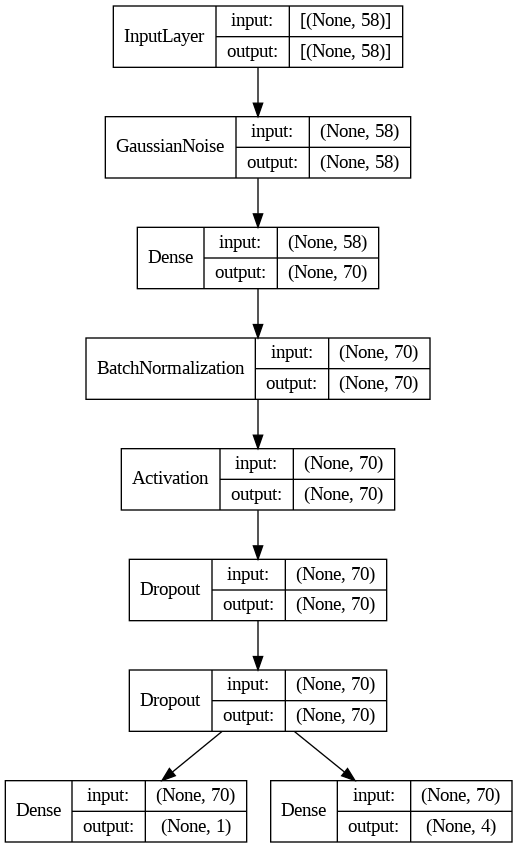

In [21]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [22]:
# opt2=tf.optimizers.Adam(0.00001)
# model.compile(optimizer=opt2, loss=losses,loss_weights=LossWeights,metrics=metrics)
# pd.DataFrame(model.get_compile_config())
# pd.DataFrame(sample_weight)

In [23]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_MLP2.h5", save_best_only=True)
history=model.fit(input_train,[output_train_sev,output_train_label],
                  validation_data=(input_val,[output_val_sev,output_val_label]),
                  epochs=300, batch_size=round(input_train.shape[0]/8),sample_weight=sample_weight,callbacks=[checkpoint_cb])

Epoch 1/300
8/8 [==============================] - 5s 60ms/step - loss: 12.0307 - outSev_loss: 4.6500 - outLabel_loss: 1.2162 - outSev_root_mean_squared_error: 1.9544 - outLabel_accuracy: 0.2812 - val_loss: 6.9482 - val_outSev_loss: 0.6237 - val_outLabel_loss: 0.9650 - val_outSev_root_mean_squared_error: 0.7897 - val_outLabel_accuracy: 0.4693
Epoch 2/300
8/8 [==============================] - ETA: 0s - loss: 7.3544 - outSev_loss: 1.6540 - outLabel_loss: 0.8350 - outSev_root_mean_squared_error: 1.2394 - outLabel_accuracy: 0.4559

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 20ms/step - loss: 7.3544 - outSev_loss: 1.6540 - outLabel_loss: 0.8350 - outSev_root_mean_squared_error: 1.2394 - outLabel_accuracy: 0.4559 - val_loss: 5.9387 - val_outSev_loss: 0.4523 - val_outLabel_loss: 0.8390 - val_outSev_root_mean_squared_error: 0.6725 - val_outLabel_accuracy: 0.5758
Epoch 3/300
8/8 [==============================] - 0s 20ms/step - loss: 5.4029 - outSev_loss: 1.0113 - outLabel_loss: 0.5784 - outSev_root_mean_squared_error: 0.8964 - outLabel_accuracy: 0.6286 - val_loss: 5.1588 - val_outSev_loss: 0.4900 - val_outLabel_loss: 0.7241 - val_outSev_root_mean_squared_error: 0.7000 - val_outLabel_accuracy: 0.6697
Epoch 4/300
8/8 [==============================] - 0s 22ms/step - loss: 4.2026 - outSev_loss: 0.8113 - outLabel_loss: 0.4078 - outSev_root_mean_squared_error: 0.7814 - outLabel_accuracy: 0.7667 - val_loss: 4.4122 - val_outSev_loss: 0.5415 - val_outLabel_loss: 0.6048 - val_outSev_root_mean_squared_error: 0.7359 - val_outLab

## Evaluating the model using Learning Curve
In this section of the notebook, we will plot the learning curve to visualize the performance of our model as the training data size increases. The learning curve provides valuable insights into how well our model generalizes and whether it is underfitting or overfitting.

First we implementing learning plot.

In [32]:
def LC_plt(train,val, StartPoint=1,train_Label='Training Loss',
           val_Label='Validation Loss',title='Training and Validation Loss',ylabel='Loss'):
  # Get the training and validation loss from the history object
  # Get the training and validation loss from the 50th epoch onwards
  training_loss = train[StartPoint:]  # Adjust index based on 0-indexing
  validation_loss = val[StartPoint:]  # Adjust index based on 0-indexing

  # Plot the learning curve
  epochs = range(StartPoint, len(training_loss) + StartPoint)  # Adjust the starting epoch
  plt.plot(epochs, training_loss, 'r', label=train_Label)
  plt.plot(epochs, validation_loss, 'b', label=val_Label)
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()


In [33]:
def PreAcc(model,input,output):
  y_true=tf.argmax(output,axis=1)
  y_pred=tf.argmax(model.predict(input)[1],axis=1)
  # Initialize the Accuracy object
  accuracy_obj = tf.keras.metrics.Accuracy()

  # Update state with predictions and ground truth labels
  accuracy_obj.update_state(y_true, y_pred)

  # Get the accuracy value
  accuracy_value = accuracy_obj.result().numpy()

  print("Accuracy: ", accuracy_value)

In [34]:
  model2=tf.keras.models.load_model("best_MLP2.h5")
  PreAcc(model2,input_test,output_test_label)
  PreAcc(model2,input_val,output_val_label)

  PreAcc(model2,input_train,output_train_label)

33/33 [==============================] - 0s 3ms/step
Accuracy:  0.9022265
35/35 [==============================] - 0s 2ms/step
Accuracy:  0.9133574
108/108 [==============================] - 0s 3ms/step
Accuracy:  1.0


In [35]:
  # model2=tf.keras.models.load_model("best_MLP2.h5")
  PreAcc(model,input_test,output_test_label)
  PreAcc(model,input_val,output_val_label)

  PreAcc(model,input_train,output_train_label)

33/33 [==============================] - 0s 2ms/step
Accuracy:  0.8983543
35/35 [==============================] - 0s 2ms/step
Accuracy:  0.883574
108/108 [==============================] - 0s 2ms/step
Accuracy:  1.0


In [28]:
losses_outlabel_train=history.history['outLabel_loss']
losses_outlabel_val=history.history['val_outLabel_loss']

losses_outsev_train=history.history['outSev_loss']
losses_outsev_val=history.history['val_outSev_loss']

losses__train=history.history['loss']
losses_val=history.history['val_loss']

accuracy_val=history.history['val_outLabel_accuracy']
accuracy_train=history.history['outLabel_accuracy']

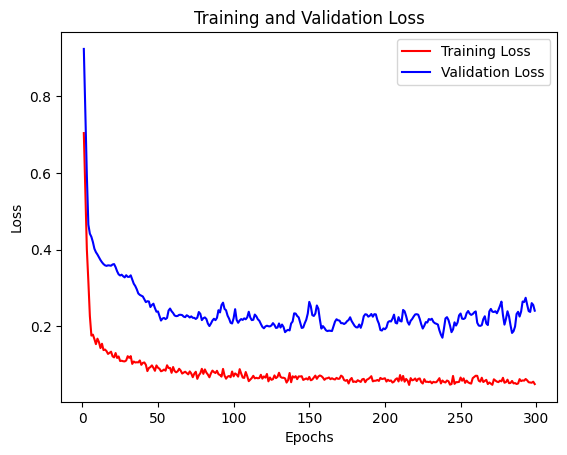

In [29]:
LC_plt(losses_outlabel_train,losses_outlabel_val,StartPoint=1)

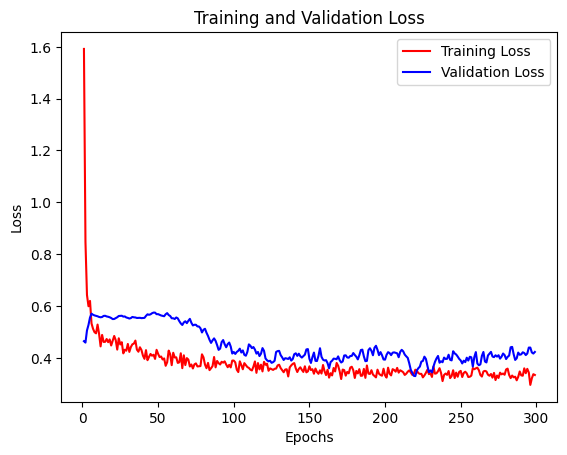

In [30]:
LC_plt(losses_outsev_train,losses_outsev_val,StartPoint=1)

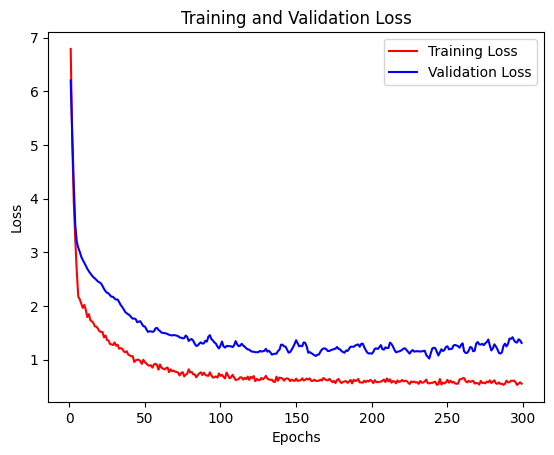

In [31]:
LC_plt(losses__train,losses_val,StartPoint=1)

# Saving Models in Google Drive

In [ ]:
model_path1='/content/drive/MyDrive/Master Thesis/Models/SVM.h5'
model_path2='/content/drive/MyDrive/Master Thesis/Models/RF.h5'
model_path3='/content/drive/MyDrive/Master Thesis/Models/MLP.keras'
joblib.dump(svm_model, model_path1)
joblib.dump(clf, model_path2)
model2.save(model_path3)

# Defining Ensemble Learning Model

## Loading Models

In [19]:
# !pip install tensorflow==2.14.0
import tensorflow as tf
print(tf.__version__)

2.14.0


In [20]:
from tensorflow.keras.models import load_model
model_path1='/content/drive/MyDrive/Master Thesis/Models/SVM.h5'
model_path2='/content/drive/MyDrive/Master Thesis/Models/RF.h5'
model_path3='/content/drive/MyDrive/Master Thesis/Models/MLP.keras'
SVM = joblib.load(model_path1)
clf = joblib.load(model_path2)
MLP = load_model(model_path3)

## Defining ensemble learning

In [23]:
from sklearn.metrics import confusion_matrix
from scipy import stats
def ensemble_and_evaluate(models, X_test, y_test):
  # models is a list of your trained models
  # X_test is your test data
  # y_test are the true labels of your test data
  model_pred=[]
  Y_Test2=tf.argmax(y_test,axis=1)
  Y_Test2=Y_Test2.numpy()

  for model in models:
    if hasattr(model, 'predict_proba'):
      pred=model.predict(X_test)
    else:
      pred_tot=model.predict(X_test)
      #Allocating the classification results to pred variable
      pred=tf.argmax(pred_tot[1],axis=1)
    model_pred.append(pred)
  # concatenated_matrix = np.concatenate(model_pred, axis=1)

  # Get probabilities from all models

  # Convert all predictions to numpy arrays
  probas_np = [np.array(proba) for proba in model_pred]
  probas=np.stack(probas_np,axis=1)
  hard_votes = stats.mode(probas, axis=1)[0]

  # # Get final predictions by choosing the class with highest average probability
  accuracy=accuracy_score(Y_Test2, hard_votes)

  # return final_predictions, conf_mat
  return accuracy

In [24]:
models=[MLP,SVM,clf]
accuracy=ensemble_and_evaluate(models, input_test, output_test_label)
print(accuracy)

33/33 [==============================] - 0s 5ms/step
0.9051306873184899
